In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression


# Proyecto sprint 15: Series de tiempo

Descripción del proyecto:

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

Instrucciones del proyecto: 

- Descarga los datos y remuestréalos de tal forma que cada punto de datos de los datos originales caigan dentro de intervalos de una hora.

- Analiza los datos.

- Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.

- Prueba los datos usando la muestra de prueba y proporciona una conclusión.


In [5]:
data = pd.read_csv('C:/Users/gabri/OneDrive/TripleTen/Curso/Sprint 15/Proyecto/taxi.csv', index_col=[0], parse_dates=[0])
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [ ]:
data.info()

#Como podemos ver, los datos que nos proporcionan están completos, no hay datos nulos.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Análisis de datos

In [ ]:
#Llevamos acabo un remuestreo en los datos:

data.sort_index(inplace=True)
data = data['2018-03':'2018-08'].resample('1D').sum()

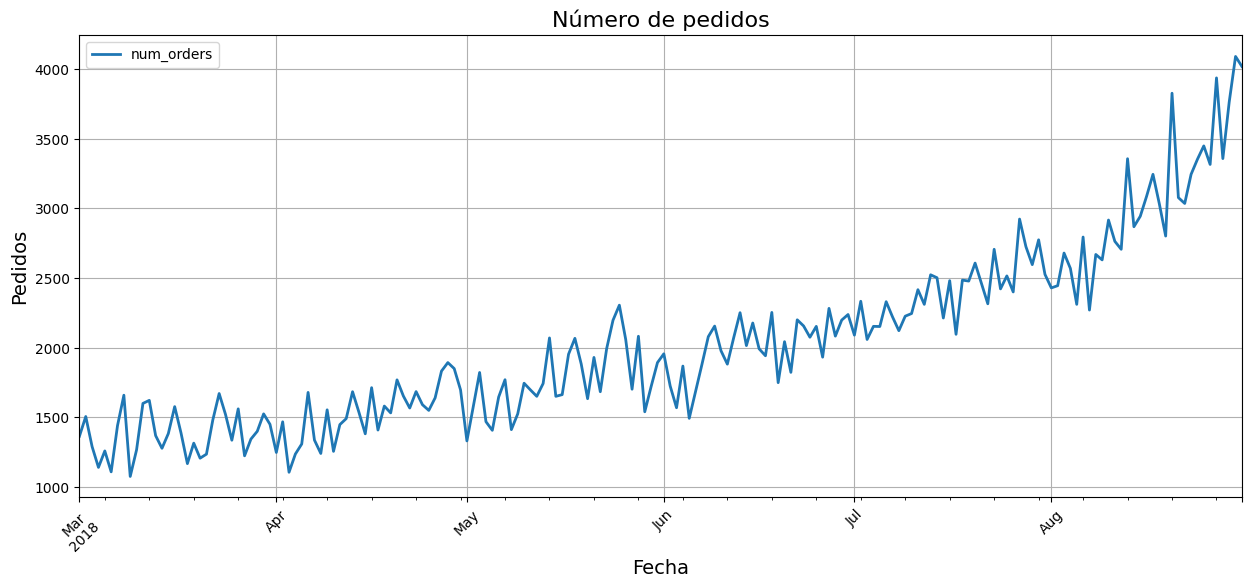

In [13]:
#Vamos a darle un vistazo a los datos con ayuda de un gráfico:
data.plot(
    y='num_orders',
    figsize=(15, 6),
    grid=True,
    color='tab:blue',   
    linewidth=2         
)

plt.title('Número de pedidos', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Pedidos', fontsize=14)
plt.xticks(rotation=45)
plt.show()

**Podemos ver una tendencia en el aumento en la demanda de taxis en el mes de agosto, es decir que, del mes de marzo en adelante se ve un incremento en dicha demanda. Dado este fenómeno ofrezco en el análisis:**

a) Cálculo de la tasa de crecimiento mensual de la demanda.

b) Hacer una descomposición de la serie de tiempo para separar la tendencia, estacionalidad y ruido.

            num_orders  Tasa_de_crecimiento
datetime                                   
2018-03-31       42768                  NaN
2018-04-30       45939             7.414422
2018-05-31       54820            19.332158
2018-06-30       59906             9.277636
2018-07-31       74405            24.202918
2018-08-31       94973            27.643304


C:\Users\gabri\AppData\Local\Temp\ipykernel_3832\1972802675.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = data.resample('M').sum() # Remuestreamos los datos a nivel mensual


<Axes: xlabel='datetime'>

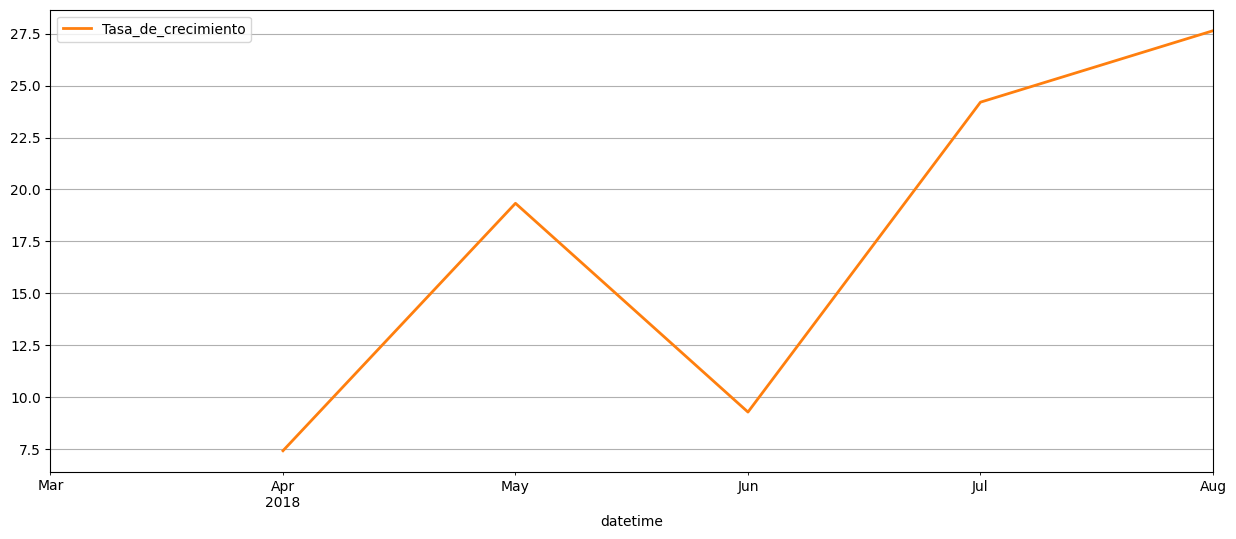

In [21]:
# a) Vamos a calcular la tasa de crecimiento mensual de la demanda.

data_monthly = data.resample('M').sum() # Remuestreamos los datos a nivel mensual
data_monthly['Tasa_de_crecimiento'] = data_monthly['num_orders'].pct_change() * 100 # Calculamos la tasa de crecimiento porcentual

print(data_monthly) 

data_monthly.plot(
    y='Tasa_de_crecimiento',
    figsize=(15, 6),
    grid=True,
    color='tab:orange',   
    linewidth=2)

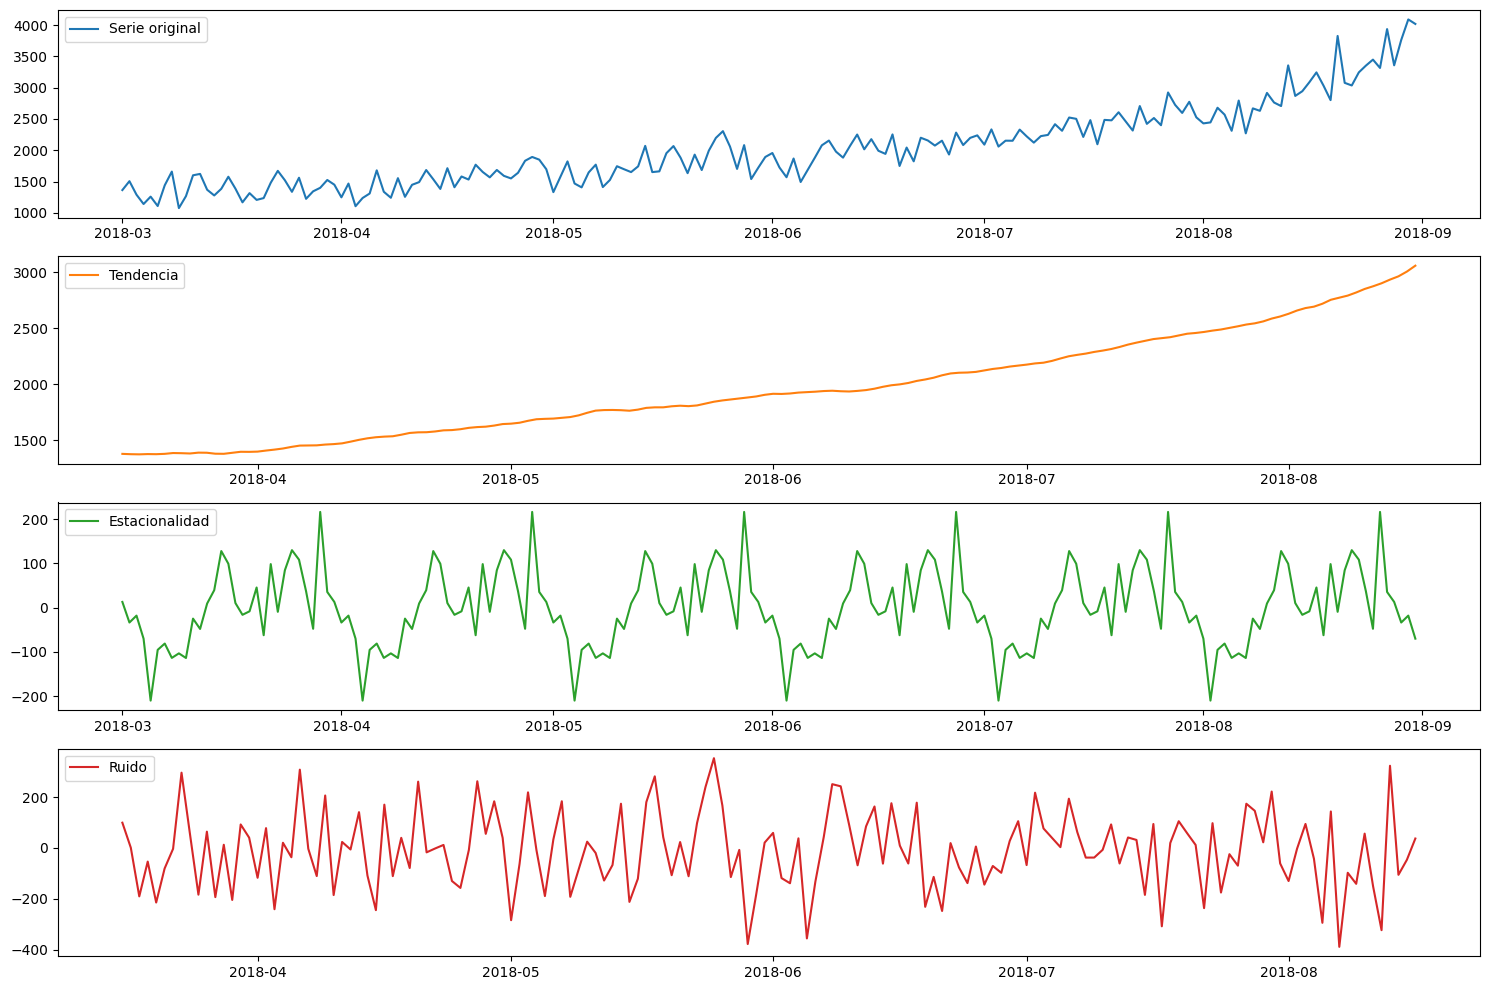

In [20]:
# Para la descomposición de la serie de tiempo para para separar la tendencia estacionalidad y ruido:


decomposition = seasonal_decompose(data['num_orders'], model='additive', period=30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid 


plt.figure(figsize=(15, 10))
plt.subplot(411)
plt.plot(data['num_orders'], label='Serie original', color='tab:blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendencia', color='tab:orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='tab:green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Ruido', color='tab:red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


**Bajo este análisis podemos apreciar que la tendencia tiene un crecimiento sostenido, y podemos identificar ciclos que nos hablan de un patrón de comportamiento en la demanda. Y por último, tenemos que el ruido, esta fluctuando al rededor de 0.**

### Entrenamiento de modelos

*$Nota_1$, Se debe tener presente en esta parte del análisis:*

Dadas n observaciones reales $y_i$  y sus predicciones $\hat{y}_i$, el EAM se calcula así:

EAM = $\frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|$

- $y_i$: valor real observado
- $\hat{y}_i$: valor predicho o estimado


¿Para qué lo usamos? 

**Lo usamos para ver que tan lejos están las predicciones de los valores reales.**

Ahora procedo a desarrollar el análisis propio a esta parte del proyecto:

a) **En esta parte del análisis, voy a usar un modelo de bosque aleatorio con caracteríricas especiales para que funcione de la mejor manera en una serie de tiempo.**

In [ ]:
#contrucción del modelo de bosque aleatorio

# Crear características de fecha
data['day_of_week'] = data.index.dayofweek
data['day_of_month'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year
data['lag_1'] = data['num_orders'].shift(1)
data['lag_7'] = data['num_orders'].shift(7)


# Dividimos los datos en conjunto de entrenamiento y prueba
X = data[['day_of_week', 'day_of_month', 'month', 'year', 'lag_1', 'lag_7']]
y = data['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=12345) #Respeto el tamaño de prueba original del 10%

# Entrenamiento del modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
#predicciones
y_pred = model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'RMSE: {mse**0.5}')
print(f'MAE: {mae}')


RMSE: 732.3615366384068
MAE: 631.1484210526315


Usé 2 criterios, ya que quiero contrastar la inflación que sufre el RMSE vs el MAE. Ya que MAE es un criterio más robusto.

b) **Ahora ofrezco el análisis propio a un modelo de referencia, para el pronóstico del modelo**

In [32]:
data.sort_index(inplace=True)
data = data.resample('1D').sum()

train, test = train_test_split(data, shuffle=False, test_size=0.1)

print('Demanda de servicio de taxi:', test['num_orders'].median()) 

pred_median = np.ones(test.shape) * train['num_orders'].median()

print('MAE:', mean_absolute_error(test,pred_median))

Demanda de servicio de taxi: 3315.0
MAE: 1398.4060150375938


Lo que pasa aquí es que np.ones(test.shape) crea un arreglo del mismo tamaño que el test, lleno de 1 y multiplicarlo por la mediana del entrenamiento hace que todas las predicciones sean ese valor constante. Y tenemos que en promedio tenemos una desviación de 1398.40 del valor real.


**d) Por último hacemos el análisis de el modelo de persistencia**

In [33]:
data.sort_index(inplace=True)
data = data.resample('1D').sum()

train, test = train_test_split(data, shuffle=False, test_size=0.1)

print('Demanda del servicio de taxi:', test['num_orders'].median())

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('MAE:', mean_absolute_error(test, pred_previous))

Demanda del servicio de taxi: 3315.0
MAE: 140.7293233082707


**Como se puede ver el error absoluto medio es mucho menor, lo que en este caso mejora significativamente el uso de este modelo, ya que tiene una precisión.**

**Entonces, entre los 3 modelos usados este último es el que se deavía menos de los valores reales, siendo el bosque aleatorio el segundo más robusto.**

### Gráficamente:

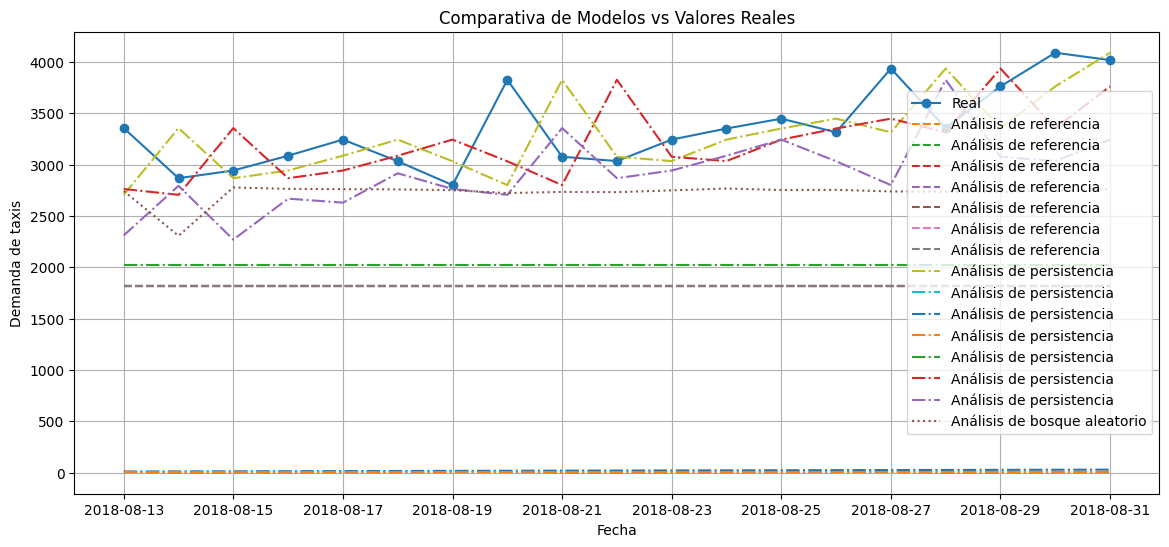

In [36]:
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Real', marker='o')
plt.plot(test.index, pred_median, label='Análisis de referencia', linestyle='--')
plt.plot(test.index, pred_previous, label='Análisis de persistencia', linestyle='-.')
plt.plot(y_test.index, y_pred, label='Análisis de bosque aleatorio', linestyle=':')
plt.title('Comparativa de Modelos vs Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Demanda de taxis')
plt.legend()
plt.grid(True)
plt.show()



###  Prueba de datos usando la muestra de prueba

**Entrenamiento por regresión lineal**

In [41]:
data.sort_index(inplace=True)
data = data.resample('1D').sum()


def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


make_features(data, 6, 10)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print(
    'EAM para el conjunto de entrenamiento:', mean_absolute_error(target_train, pred_train)
)
print('EAM para el conjunto de prueba:', mean_absolute_error(target_test, pred_test))
mse = mean_squared_error(target_test, pred_test)
print('RMSE para el conjunto de prueba:', mse**0.5)

EAM para el conjunto de entrenamiento: 118.94574873044344
EAM para el conjunto de prueba: 401.846963783044
RMSE para el conjunto de prueba: 476.17089392353455


### Conclusiones:

Este proyecto ofrece un análisis de datos basado en series de tiempo, lo que da elementos para tomar decisiones en cuanto a la oferta de productos, en este caso, la oferta de servicios de transporte. Dichos elementos, son principalmente, la tendencia y la estacionalidad, ya que ayudan a identificar patrones en el comportamiento del consumidor.

Además, en este proyecto ofrezcó un elemento importante, que es la tasa de crecimiento, en aras de visualizar más de cerca este componente conductual.

No dejé de lado los algoritmos de machine learning, ya que fueron dotados de elementos para su adecuación al análisis de series de tiempo; y como resultante, obtuve que el modelo más robusto es el modelo de persistencia, lo que es consistente con la teoría estadística; en ella se demuestra que la mediana es una medida robusta, poco perturbable de valores atípicos. Y en ese sentido, el proyecto, demuestra ese hecho estadístico.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48
